In [54]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [66]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, SpatialDropout1D, SimpleRNN
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import math
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import random

In [56]:
df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Soft Computing/Assignment 3/Dataset 1.csv', engine = 'python')
df= df.sample(frac=1).reset_index(drop= True) 

# Data Preprocessing

In [57]:
# removing mentions, links, tags

def remove_mlt(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)     # removing @mentions
    text = re.sub(r'@[A-Za-zA-Z0-9]+', '', text)  # removing @mentions 
    text = re.sub(r'@[A-Za-z]+', '', text)        # removing @mentions
    text = re.sub(r'@[-)]+', '', text)            # removing @mentions

    text = re.sub(r'https?\/\/\S+', '', text)     # removing the hyper link
    text = re.sub(r'http?\/\/\S+', '', text)     # removing the hyper link
    
    text = re.sub(r'#', '', text )              # removing '#' sign
    text = re.sub(r'RT[\s]+', '', text)         # removing RT
    text = re.sub(r'&[a-z;]+', '', text)        # removing '&gt;'
    
    return text

In [59]:
# removing stopwords, punctuations

import nltk
import string
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 


def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))  
  words = word_tokenize(text)
    #words = tokenizer.tokenize(text)
  filtered_words = [w for w in words if not w in stop_words]

  str = " "
  return str.join(filtered_words)


def remove_punctuations(text):
    words = word_tokenize(text)
    
    filtered_words = [w for w in words if not w in string.punctuation]
    
    str = " "
    return str.join(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [60]:
# Before preprocessing
df[['message', 'label']].iloc[range(5)]

,message,label
0,@funkycarla8 It is a bit of both. Got some clo...,0
1,@em_c Good try Well done with the painting by...,0
2,Meditation can contribute to your overall well...,1
3,"@SENexchange #SENexhange as above, majority of...",1
4,@SunixRS depression,1


In [61]:
# Applying preprocessing

df['message'] = df['message'].apply(remove_mlt)
df['message'] = df['message'].apply(remove_stopwords)
df['message'] = df['message'].apply(remove_punctuations)


In [62]:
# After preprocessing
df[['message', 'label']].iloc[range(5)]

,message,label
0,It bit Got clothes shoes new watch good day Th...,0
1,_c Good try Well done painting way,0
2,Meditation contribute overall well-being decre...,1
3,SENexhange majority mental health I deal relat...,1
4,depression,1


In [10]:
print(df['label'].value_counts(0))


0    8000
1    2314
Name: label, dtype: int64


# Word Embedding

In [11]:
dataset = df
unique_label = np.unique(df["label"])
num_classes = len(unique_label)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset['message'].values, pd.get_dummies(dataset['label']).values, test_size=0.20)

MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
# print(word_index)


train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)
pad_train = pad_sequences(train_seq, maxlen=MAX_SEQUENCE_LENGTH)
pad_test = pad_sequences(test_seq, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', pad_train.shape)

Found 17840 unique tokens.
Shape of data tensor: (8251, 200)


# Bidirectional RNN

In [12]:
from keras import layers
model = Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=pad_train.shape[1]))
#model.add(layers.Bidirectional(layers.SimpleRNN(10, return_sequences=True), input_shape=(5, 10)))
model.add(layers.Bidirectional(layers.SimpleRNN(100, activation= 'relu', return_sequences = True, dropout = 0.5)))
model.add(layers.Bidirectional(layers.SimpleRNN(100, activation= 'relu', return_sequences=True, dropout = 0.5)))
model.add(layers.Bidirectional(layers.SimpleRNN(100, activation= 'relu', return_sequences=True, dropout = 0.5)))
model.add(layers.Bidirectional(layers.SimpleRNN(100, activation= 'relu', dropout = 0.5)))
model.add(layers.Dense(2, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 128
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          2000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 200)          40200     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 200)          60200     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 200)          60200     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               60200     
_________________________________________________________________
dense (Dense)                (None, 2)                 402       
Total params: 2,221,202
Trainable params: 2,221,202
Non-trainable params: 0
______________________________________________

In [13]:
history = model.fit(pad_train, y_train, epochs=epochs,validation_split=0.2)

Epoch 1/10
207/207 [==============================] - 170s 788ms/step - loss: 39637816.0000 - accuracy: 0.8738 - val_loss: 0.0403 - val_accuracy: 0.9903
Epoch 2/10
207/207 [==============================] - 163s 786ms/step - loss: 21.4823 - accuracy: 0.9795 - val_loss: 0.0585 - val_accuracy: 0.9855
Epoch 3/10
207/207 [==============================] - 161s 780ms/step - loss: 0.0125 - accuracy: 0.9976 - val_loss: 0.0405 - val_accuracy: 0.9927
Epoch 4/10
207/207 [==============================] - 163s 786ms/step - loss: 0.0134 - accuracy: 0.9989 - val_loss: 0.2853 - val_accuracy: 0.9637
Epoch 5/10
207/207 [==============================] - 163s 787ms/step - loss: 0.0167 - accuracy: 0.9973 - val_loss: 0.0377 - val_accuracy: 0.9921
Epoch 6/10
207/207 [==============================] - 163s 789ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0376 - val_accuracy: 0.9909
Epoch 7/10
207/207 [==============================] - 162s 783ms/step - loss: 8.7652e-04 - accuracy: 0.9997 - val_lo

In [15]:
history = model.fit(pad_train, y_train, epochs=epochs,batch_size= batch_size)

Epoch 1/10
65/65 [==============================] - 148s 2s/step - loss: 0.0104 - accuracy: 0.9985
Epoch 2/10
65/65 [==============================] - 139s 2s/step - loss: 0.0043 - accuracy: 0.9995
Epoch 3/10
65/65 [==============================] - 145s 2s/step - loss: 0.0017 - accuracy: 0.9998
Epoch 4/10
65/65 [==============================] - 147s 2s/step - loss: 0.0026 - accuracy: 0.9998
Epoch 5/10
65/65 [==============================] - 148s 2s/step - loss: 0.0019 - accuracy: 0.9996
Epoch 6/10
65/65 [==============================] - 148s 2s/step - loss: 0.0022 - accuracy: 0.9998
Epoch 7/10
65/65 [==============================] - 152s 2s/step - loss: 0.0031 - accuracy: 0.9994
Epoch 8/10
65/65 [==============================] - 145s 2s/step - loss: 0.0018 - accuracy: 0.9998
Epoch 9/10
65/65 [==============================] - 139s 2s/step - loss: 0.0019 - accuracy: 0.9995
Epoch 10/10
65/65 [==============================] - 137s 2s/step - loss: 0.0018 - accuracy: 0.9998


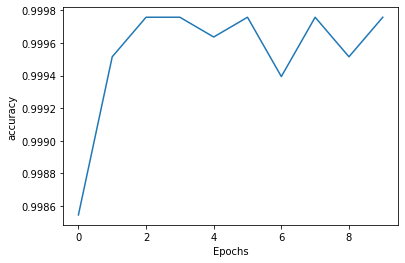

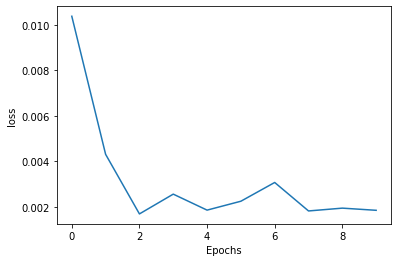

In [26]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Confusion Matrix (Train Data)

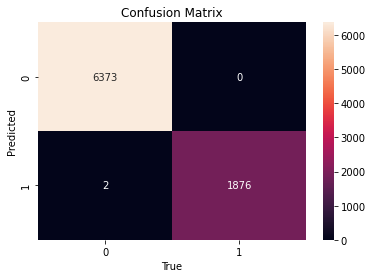

In [63]:
y_pred = model.predict(pad_train)

new_y_pred = np.argmax(y_pred, axis=1)
new_y_train = np.argmax(y_train, axis=1)

sb.heatmap(confusion_matrix(new_y_train, new_y_pred), annot = True, fmt = 'g')
plt.title('Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.show()

# Model Performance (Train Data)

In [67]:
evaluation = model.evaluate(pad_train,y_train)
accuracy = evaluation[1] * 100
precision =   precision_score(new_y_train, new_y_pred) * 100
recall =  recall_score(new_y_train, new_y_pred) * 100
f1_score =  f1_score(new_y_train, new_y_pred) * 100
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1_score)

258/258 [==============================] - 37s 144ms/step - loss: 7.4747e-04 - accuracy: 0.9998
Accuracy:  99.97575879096985
Precision:  100.0
Recall:  99.89350372736953
F1-Score:  99.94672349493872


# Confusion Matrix (Test Data)

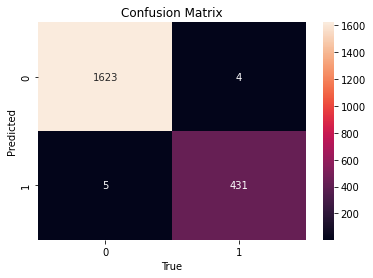

In [36]:
y_pred = model.predict(pad_test)

new_y_pred = np.argmax(y_pred, axis=1)
new_y_test = np.argmax(y_test, axis=1)

sb.heatmap(confusion_matrix(new_y_test, new_y_pred), annot = True, fmt = 'g')
plt.title('Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.show()


# Model Performance (Test Data)

In [49]:
evaluation = model.evaluate(pad_test,y_test)
accuracy = evaluation[1] * 100
precision =   precision_score(new_y_test, new_y_pred) * 100
recall =  recall_score(new_y_test, new_y_pred) * 100
f1_score =  f1_score(new_y_test, new_y_pred) * 100
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1_score)


65/65 [==============================] - 10s 150ms/step - loss: 0.0280 - accuracy: 0.9956
Accuracy:  99.56374168395996
Precision:  99.08045977011494
Recall:  98.85321100917432
F1-Score:  98.96670493685419
